# 3. Time Series
© Danish Haroon 2017

Danish Haroon, Python Machine Learning Case Studies, https://doi.org/10.1007/978-1-4842-2823-4_3

In [1]:
%matplotlib inline

from scipy.stats import norm
from math import sqrt
import re
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup as bs
#from matplotlib.finance import fetch_historical_yahoo, parse_yahoo_historical_ochl

rcParams['figure.figsize'] = 15, 5

**Load data by crawling from the web** 

In [2]:
#I had to use a workaround.

def get_historical_data(name, period):
    d, dates, values = [], [], []
    url = "https://finance.yahoo.com/quote/" + name + "/history/" + period
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    req = Request(url, headers=headers)
    html = urlopen(req).read()
    soup = bs(html, 'html.parser')
    
    rows = soup.findAll('table')[0].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        if len(divs) > 6 and divs[1] and divs[1].text != 'Dividend': #Ignore this row in the table

            # Retrieve date in col[0]
            data_text = divs[0].text
            date_str = datetime.strptime(data_text, "%b %d, %Y").date().isoformat()
            date_obj = datetime.fromisoformat(date_str)
            # Retrieve remaining infor col[1:]
            open_price = float(divs[1].text.replace(',',''))
            high_price = float(divs[2].text.replace(',',''))
            low_price = float(divs[3].text.replace(',',''))
            close_price = float(divs[4].text.replace(',',''))
            adj_close_price = float(divs[5].text.replace(',',''))
            volume = int(divs[6].text.replace(',', ''))
            
            d.append({
                'Date': date_obj,
                'Year': date_obj.year,
                'Month': date_obj.month,
                'Day': date_obj.day,
                'D': float(date_obj.day),
                'Open': open_price,
                'Close': close_price,
                'High': high_price,
                'Low': low_price,
                'Volume': volume,
                'adjusted_close': adj_close_price            
            })
            dates.append(date_obj)
            values.append(adj_close_price)
            
        else:
            return "Data not retrieved"
    
    yahoo_data = pd.DataFrame({"Close_Adj": values}, index=dates)
    return yahoo_data

#Test
data = get_historical_data('%5EGSPC', "?period1=1451606400&period2=1483142400")
data = data.sort_index()
data.head()

,Close_Adj
2016-01-04,2012.66
2016-01-05,2016.71
2016-01-06,1990.26
2016-01-07,1943.09
2016-01-08,1922.03


**Plot adjusted closing rate of yahoo stock for 2016 on a time series**

Text(0.5, 1.0, 'Yahoo Adjusted closing rate - Year 2016')

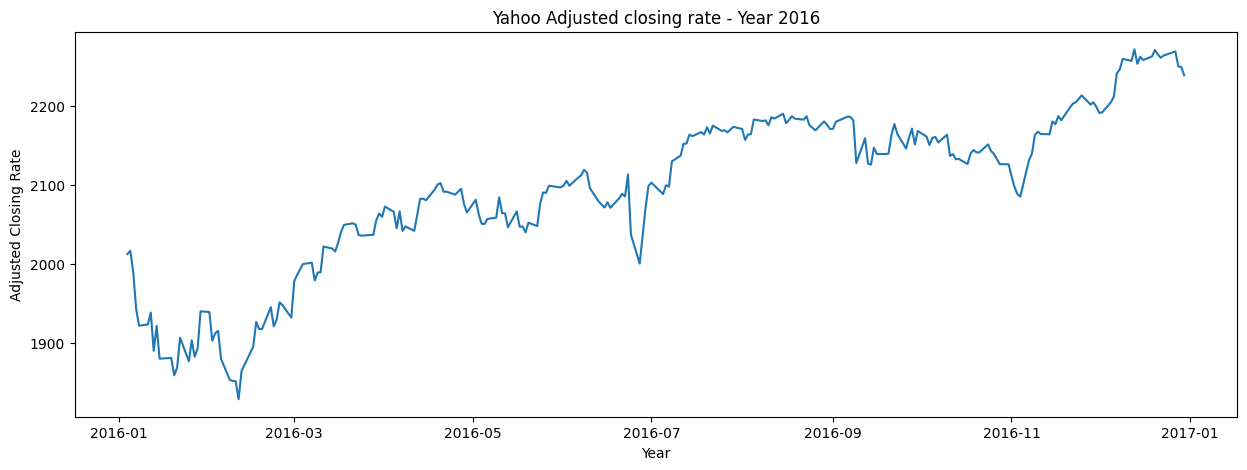

In [3]:
date_thresh = datetime.strptime('2016-10-01',"%Y-%m-%d").date()

data_train = data[:date_thresh]
data_test = data[date_thresh:]

plt.plot(data.index, data['Close_Adj'])
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Yahoo Adjusted closing rate - Year 2016')

In [4]:
data_train.size, data_test.size

(189, 63)

**Evaluate if a time series object is stationary**

In [5]:
def evaluate_stationarity(timeseries, t=30):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

**Test if time series object is stationary**

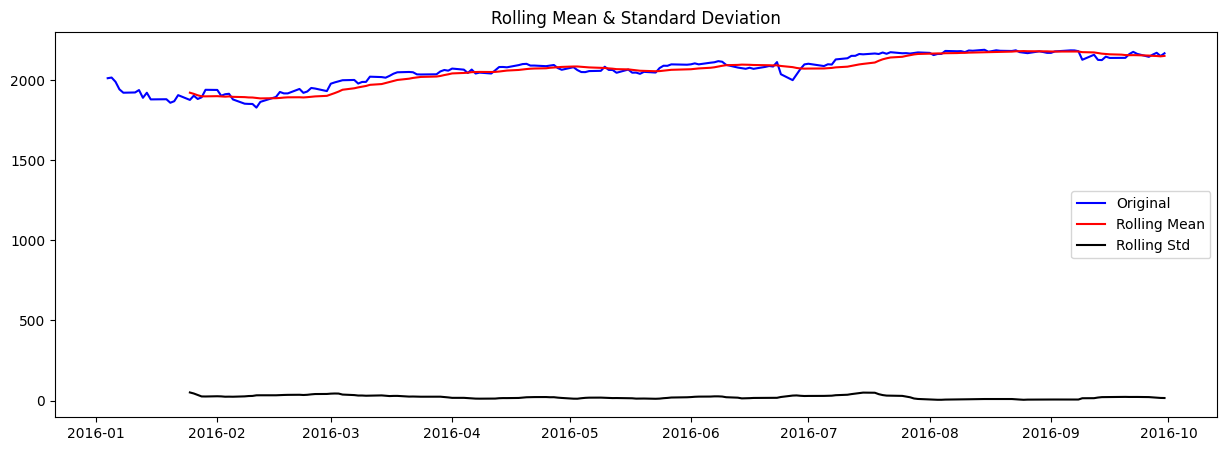

Results of Dickey-Fuller Test:
Test Statistic                  -1.114303
p-value                          0.709335
#Lags Used                       0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [6]:
evaluate_stationarity(data_train['Close_Adj'], 15) # not stationary

In [7]:
def critical_z(p):
    norm_distr = norm(loc=0.0, scale=4.0)
    lower_tail = (1.0 - p)/ 2.0
    upper_tail = 1.0 - ((1.0 - p) / 2.0)
    return norm_distr.ppf(lower_tail), norm_distr.ppf(upper_tail)

print(critical_z(0.95))

(np.float64(-7.839855938160216), np.float64(7.839855938160216))


In [8]:
def confidence_interval(p, sample_mean, sample_std, n):
    lower, upper = critical_z(p)
    
    lower_ci = (lower * (sample_std / sqrt(n)))*-1
    upper_ci = upper * (sample_std / sqrt(n))

    return sample_mean - lower_ci, sample_mean + upper_ci


print(confidence_interval(0.95, 18.0, 1.5, 31))


(np.float64(15.887880459570495), np.float64(20.112119540429504))
